<a href="https://colab.research.google.com/github/James-Bartman/IEOR142_Project/blob/main/IEOR_142_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IEOR 142 Final Project**
#### James Bartman, Taras Goral, Sarah Parkes, Negar Sheidayi, and Emme Spero

**INSTRUCTIONS FOR GROUP MEMBERS:**
1. Run all cells in Part 1: Dependencies
2. Run Data Import cells in Part 3: Importing Preprocessed Data
3. Run function declaration cells in Part 4: Data Inspection
4. Do whatever modeling you are responsible for in its own subsection and make sure to have a text cell before it specifying which model you are running.

## Part I: Dependencies

In [1]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn
import datetime
import time

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import accuracy_score, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
# Filepath selection
%cd drive/My \Drive/IEOR \142\ Project/DATA

/content/drive/.shortcut-targets-by-id/1KTfVJfYEtZ8Wg_v95FrlVJvkRVR0FNfA/IEOR 142 Project/DATA


## Part II: Data Upload, Cleaning, and Preprocessing

### BART Ridership Data

In [ ]:
colnames = ["date", "hour", "start_station", "end_station", "num_riders"]
abbr = pd.read_csv("Bart-Station-Abbr.csv")
abbr.drop(columns = ['Abbr Low'], inplace=True)

FileNotFoundError: ignored

In [ ]:
# processing function - convert stations to general regions
def groupby_region (year_df, abbr):
  year_df = year_df.join(abbr.set_index('Abbr'), on='start_station')
  year_df = year_df.rename(columns={"Region": "start_region"})
  year_df.drop(columns = ['Station Name'], inplace=True)
  year_df = year_df.join(abbr.set_index('Abbr'), on='end_station')
  year_df = year_df.rename(columns={"Region": "end_region"})
  year_df.drop(columns = ['Station Name'], inplace=True)
  year_df = year_df.groupby(['date', 'hour', 'start_region', 'end_region']).sum().reset_index()
  return year_df[['date', 'hour', 'start_region', 'end_region', 'num_riders']]

def groupby_dayhour(year_df):
  year_df = year_df.groupby(['date', 'hour']).sum().reset_index()
  return year_df[['date', 'hour', 'num_riders']]

In [ ]:
d2011 = pd.read_csv("d2011.csv", names=colnames, header=None)
d2012 = pd.read_csv("d2012.csv", names=colnames, header=None)
d2013 = pd.read_csv("d2013.csv", names=colnames, header=None)
d2014 = pd.read_csv("d2014.csv", names=colnames, header=None)
d2015 = pd.read_csv("d2015.csv", names=colnames, header=None)
d2016 = pd.read_csv("d2016.csv", names=colnames, header=None)
d2017 = pd.read_csv("d2017.csv", names=colnames, header=None)
d2018 = pd.read_csv("d2018.csv", names=colnames, header=None)
d2019 = pd.read_csv("d2019.csv", names=colnames, header=None)
d2020 = pd.read_csv("d2020.csv", names=colnames, header=None)
d2021 = pd.read_csv("d2021.csv", names=colnames, header=None)
d2022 = pd.read_csv("d2022.csv", names=colnames, header=None)

In [ ]:
d2011 = groupby_dayhour(d2011)
d2012 = groupby_dayhour(d2012)
d2013 = groupby_dayhour(d2013)
d2014 = groupby_dayhour(d2014)
d2015 = groupby_dayhour(d2015)
d2016 = groupby_dayhour(d2016)
d2017 = groupby_dayhour(d2017)
d2018 = groupby_dayhour(d2018)
d2019 = groupby_dayhour(d2019)
d2020 = groupby_dayhour(d2020)
d2021 = groupby_dayhour(d2021)
d2022 = groupby_dayhour(d2022)

In [ ]:
bart = pd.concat([d2011, d2012, d2013, d2014, d2015, d2016, d2017, d2018, d2019, d2020, d2021, d2022], axis=0, ignore_index=True)
# convert to datetime
bart["date"] = pd.to_datetime(bart["date"], infer_datetime_format = True)

In [ ]:
bart = bart.groupby(['date', 'hour']).mean().reset_index()
bart = bart.sort_values(['date', 'hour'])
print(bart.shape)
bart.head()

### Data Consistency

In [ ]:
# Add correct indicies
for index, row in bart.iterrows():
  if(index%10000 == 0):
    print("index:", index)
  init_date = datetime.datetime(2011, 1, 1)
  elapsed = row['date'] - init_date
  total = elapsed.days * 24 + row['hour']
  bart.loc[index, ['prime']] = total

In [ ]:
# Find missing rows
news, hours, zers, primes = [], [], [], []
i = 0
for index, row in bart.iterrows():
  p = row['prime']
  while (i < p):
    ind = i
    days_elapsed = ind//24
    hours.append(ind%24)
    news.append(init_date + datetime.timedelta(days=days_elapsed))
    zers.append(0)
    primes.append(ind)
    i += 1
  i += 1

In [ ]:
# Add in missing rows
map = {
    "date": news,
    "hour": hours,
    "num_riders": zers,
    "prime": primes
}

df2 = pd.DataFrame(map)
df2.shape
bart = pd.concat([bart, df2], ignore_index = True)

In [ ]:
# Re-index based on proper indicies
bart = bart.sort_values('prime')
bart.reset_index(inplace=True)
bart.tail()

In [ ]:
# Drop extra index column
print(bart.shape)
bart.drop(columns = ['index', 'prime'], inplace = True)
bart.head()

In [ ]:
bart['yesterday'] = bart['transbayUtil'].shift(24)
bart['lastHour'] = bart['transbayUtil'].shift(1)
bart['dayOfWeek'] = bart['date'].dt.day_name()

### Special Events Data

In [ ]:
df_sf = pd.read_csv('SFGiants.csv')
df_oa = pd.read_csv('OaklandAs.csv')

# Only home games
mask = df_sf['Opponent'].str[:2] == 'vs'
df_sf = df_sf[mask]
mask = df_oa['Opponent'].str[:2] == 'vs'
df_oa = df_oa[mask]

In [ ]:
bart['date'] = bart['datetime'].dt.date
bart["date"] = pd.to_datetime(bart["date"], infer_datetime_format = True)

In [ ]:
df_oa["Date"] = pd.to_datetime(df_oa["Date"], infer_datetime_format = True)
df_sf["Date"] = pd.to_datetime(df_sf["Date"], infer_datetime_format = True)

bart['sfGiants'] = bart['date'].isin(df_sf['Date']).astype(int)
bart['oakAs'] = bart['date'].isin(df_oa['Date']).astype(int)
bart.drop(columns = ['date'], inplace = True)

In [ ]:
# Write out csv
bart.to_csv('bartHour_1122.csv') 
files.download('bartHour_1122.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Taras's Data Processing

In [ ]:
# Processing Taras's 2021-2022 Data
bart = pd.read_csv("bartDataset20112022.csv")
bart.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
bart["datetime"] = pd.to_datetime(bart["datetime"], infer_datetime_format = True)

In [ ]:
bart['Date'] = bart['datetime'].dt.date
bart['sfGiants'] = bart['Date'].isin(df_sf['Date']).astype(int)
bart['oakAs'] = bart['Date'].isin(df_oa['Date']).astype(int)

bart['lastHour'] = bart['transbayRides'].shift(1)
bart['yesterday'] = bart['transbayRides'].shift(24)
bart.head()

In [ ]:
bart.drop(columns = ['Date'], inplace = True)
bart.head()

In [ ]:
bart.to_csv('bartDataset20112022.csv')
files.download('bartDataset20112022.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Part III: Importing Preprocessed Data

In [5]:
bart = pd.read_csv("bartDataset20112022.csv")
bart.drop(columns=["Unnamed: 0"], inplace=True)
bart["datetime"] = pd.to_datetime(bart["datetime"], infer_datetime_format = True)

In [6]:
# combine date and hour into datetime 
# bart.insert(0, 'datetime', pd.to_datetime(bart_hourly["date"]) + bart_hourly["hour"].astype('timedelta64[h]'))
bart.tail()

,datetime,transbayRides,systemRides,transbayUtil,travelTime,dayOfWeek,sfoAirTemp,sfoPrecip,oakAirTemp,oakPrecip,spareAirDay,yesterday,lastHour,sfGiants,oakAs
104443,2022-11-30 19:00:00,4043.0,6912.0,0.584925,18.462500,Wednesday,11.1,0.0,11.1,0.0,0.0,0.585805,0.588341,0,0
104444,2022-11-30 20:00:00,2184.0,3933.0,0.555301,15.990000,Wednesday,11.1,0.0,10.6,0.0,0.0,0.554697,0.584925,0,0
104445,2022-11-30 21:00:00,1278.0,2513.0,0.508556,15.918333,Wednesday,11.1,0.0,10.6,0.0,0.0,0.512934,0.555301,0,0
104446,2022-11-30 22:00:00,1368.0,2555.0,0.535421,15.985000,Wednesday,11.1,0.0,10.6,0.0,0.0,0.520000,0.508556,0,0
104447,2022-11-30 23:00:00,1050.0,1848.0,0.568182,16.170833,Wednesday,11.1,0.0,8.9,0.0,0.0,0.571894,0.535421,0,0


In [7]:
bart_train = bart[bart['datetime'].dt.year <= 2020]
bart_test = bart[bart['datetime'].dt.year > 2020]

## Part IV: Data Inspection

In [8]:
def plot_entire_series(x, y, **kwargs):
    
    plt.figure(figsize=(16, 4))
    plt.plot(x, y, linewidth=2, color='black')
    
    for key, value in kwargs.items():
        plt.plot(x, value, linewidth=2, color=key)
        
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Util', fontsize=16)
    plt.show()
    
    return None

def plot_last_fifty(x, y, **kwargs):
    
    plt.figure(figsize=(16, 4))
    plt.scatter(x[-50:], y[-50:], linewidth=3, color='black')
    plt.plot(x[-50:], y[-50:], linewidth=3, color='black')
    
    for key, value in kwargs.items():
        plt.plot(x[-50:], value[-50:], linewidth=3, color=key)
        
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Util', fontsize=16)
    plt.show()
    
    return None

def plot_last_five_hundred(x, y, **kwargs):
    
    plt.figure(figsize=(16, 4))
    plt.scatter(x[-500:], y[-500:], linewidth=3, color='black')
    plt.plot(x[-500:], y[-500:], linewidth=3, color='black')
    
    for key, value in kwargs.items():
        plt.plot(x[-500:], value[-500:], linewidth=3, color=key)
        
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Util', fontsize=16)
    plt.show()
    
    return None

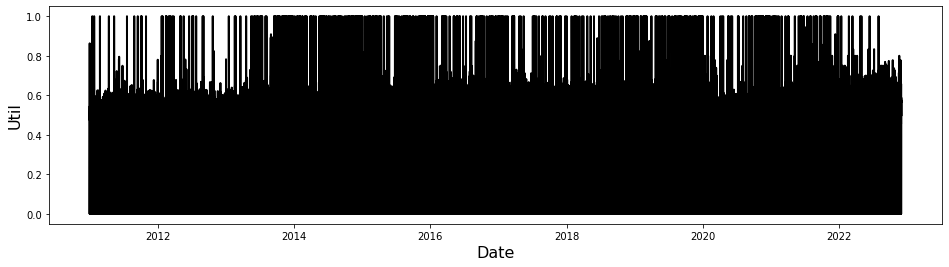

In [9]:
x = bart['datetime'].to_numpy()
y = bart['transbayUtil'].to_numpy()

# Utilization: transbay/total riders
plot_entire_series(x, y)

## Part V: Linear Models

In [10]:
def OSR2(y_train, y_test, y_pred):
    
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)          
    return (1 - SSE/SST)
  
def RMSE(y_test, y_pred):
    return np.sqrt(np.sum((y_test - y_pred)**2)/len(y_test))

def MAE(y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred))/len(y_test)

def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

### Section A: Linear Trend

In [11]:
time_period = list(range(len(bart_train)))
bart_train['timePeriod'] = time_period
bart_train.tail()

<ipython-input-11-d3325dc56c67>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bart_train['timePeriod'] = time_period


,datetime,transbayRides,systemRides,transbayUtil,travelTime,dayOfWeek,sfoAirTemp,sfoPrecip,oakAirTemp,oakPrecip,spareAirDay,yesterday,lastHour,sfGiants,oakAs,timePeriod
87667,2020-12-31 19:00:00,684.0,1357.0,0.504053,16.475,Thursday,11.7,0.0,11.7,0.0,0.0,0.517483,0.506167,0,0,87667
87668,2020-12-31 20:00:00,410.0,866.0,0.473441,16.475,Thursday,11.1,0.0,9.4,0.0,0.0,0.493209,0.504053,0,0,87668
87669,2020-12-31 21:00:00,328.0,676.0,0.485207,16.475,Thursday,10.0,0.0,10.0,0.0,0.0,0.502347,0.473441,0,0,87669
87670,2020-12-31 22:00:00,115.0,213.0,0.539906,16.475,Thursday,8.9,0.0,9.4,0.0,0.0,0.518797,0.485207,0,0,87670
87671,2020-12-31 23:00:00,2.0,8.0,0.250000,16.475,Thursday,8.9,0.0,8.9,0.0,0.0,0.500000,0.539906,0,0,87671


In [12]:
lm = smf.ols(formula='transbayUtil ~ timePeriod', data=bart_train).fit()
print(lm.summary())
print('Training RMSE:', round(RMSE(bart_train['transbayUtil'], lm.predict(bart_train)), 3))
print('Training MAE:', round(MAE(bart_train['transbayUtil'], lm.predict(bart_train)), 3))

                            OLS Regression Results                            
Dep. Variable:           transbayUtil   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     74.81
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           5.28e-18
Time:                        00:03:20   Log-Likelihood:                 25822.
No. Observations:               87672   AIC:                        -5.164e+04
Df Residuals:                   87670   BIC:                        -5.162e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4400      0.001    361.429      0.0

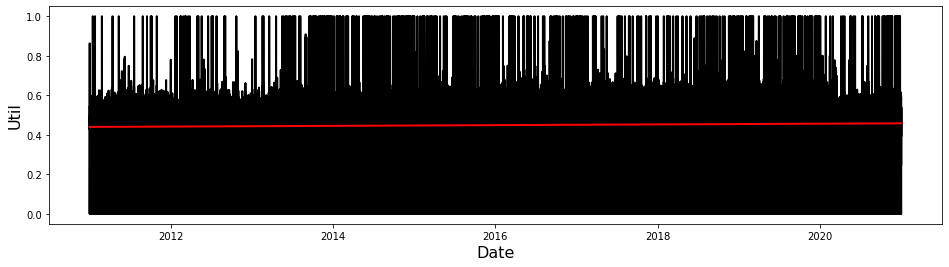

In [13]:
x = bart_train['datetime'].to_numpy()
y = bart_train['transbayUtil'].to_numpy()
y_pred = lm.predict(bart_train).to_numpy()

plot_entire_series(x, y, red=y_pred)

In [14]:
bart_train.drop(columns = ['timePeriod'], inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Section B: Auto-Regressive Models

In [15]:
ar1 = smf.ols(formula='transbayUtil ~ yesterday', data=bart_train).fit()
print(ar1.summary())

                            OLS Regression Results                            
Dep. Variable:           transbayUtil   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                 6.445e+04
Date:                Fri, 16 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:03:23   Log-Likelihood:                 49935.
No. Observations:               87648   AIC:                        -9.987e+04
Df Residuals:                   87646   BIC:                        -9.985e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1567      0.001    126.296      0.0

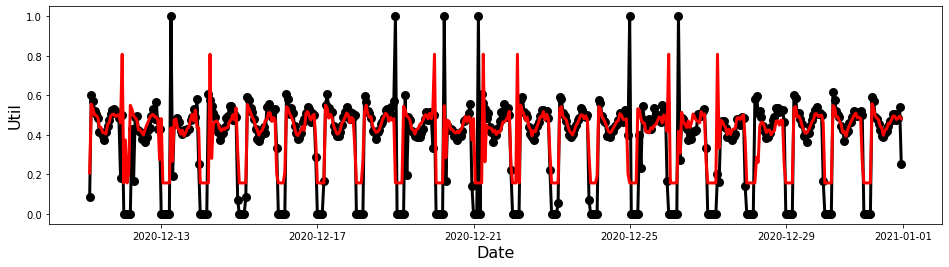

In [16]:
y_pred = ar1.predict(bart_train).to_numpy()
plot_last_five_hundred(x, y, red=y_pred)

In [17]:
bart_train.head()

,datetime,transbayRides,systemRides,transbayUtil,travelTime,dayOfWeek,sfoAirTemp,sfoPrecip,oakAirTemp,oakPrecip,spareAirDay,yesterday,lastHour,sfGiants,oakAs
0,2011-01-01 00:00:00,2473.0,5175.0,0.477874,15.669167,Saturday,8.9,0.0,8.9,-0.1,0.0,NaN,NaN,0,0
1,2011-01-01 01:00:00,9884.0,15479.0,0.638543,16.778333,Saturday,8.9,0.3,8.9,0.3,0.0,NaN,0.477874,0,0
2,2011-01-01 02:00:00,7050.0,11055.0,0.637720,16.237500,Saturday,8.3,0.5,8.9,0.3,0.0,NaN,0.638543,0,0
3,2011-01-01 03:00:00,4135.0,5592.0,0.739449,15.604167,Saturday,8.9,-0.1,8.9,0.3,0.0,NaN,0.637720,0,0
4,2011-01-01 04:00:00,686.0,795.0,0.862893,15.732500,Saturday,8.9,-0.1,9.4,-0.1,0.0,NaN,0.739449,0,0


In [18]:
ar2 = smf.ols(formula='transbayUtil ~ travelTime + dayOfWeek + sfoAirTemp + sfoPrecip + oakAirTemp + oakPrecip + spareAirDay + yesterday + lastHour + sfGiants + oakAs', data=bart_train).fit()
print(ar2.summary())
print('Training RMSE:', round(RMSE(bart_train['transbayUtil'], ar2.predict(bart_train)), 3))
print('Training MAE:', round(MAE(bart_train['transbayUtil'], ar2.predict(bart_train)), 3))

                            OLS Regression Results                            
Dep. Variable:           transbayUtil   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     6085.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:03:26   Log-Likelihood:                 58523.
No. Observations:               87648   AIC:                        -1.170e+05
Df Residuals:                   87631   BIC:                        -1.169e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [19]:
cols = ['travelTime','sfoAirTemp', 'sfoPrecip', 'oakAirTemp', 'oakPrecip', 'spareAirDay', 'yesterday', 'lastHour', 'sfGiants', 'oakAs']
VIF(bart_train[24:], cols)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


travelTime     1.122609
sfoAirTemp     8.746268
sfoPrecip      2.148049
oakAirTemp     8.744319
oakPrecip      2.145973
spareAirDay    1.066153
yesterday      1.244455
lastHour       1.262533
sfGiants       1.073935
oakAs          1.075910
dtype: float64

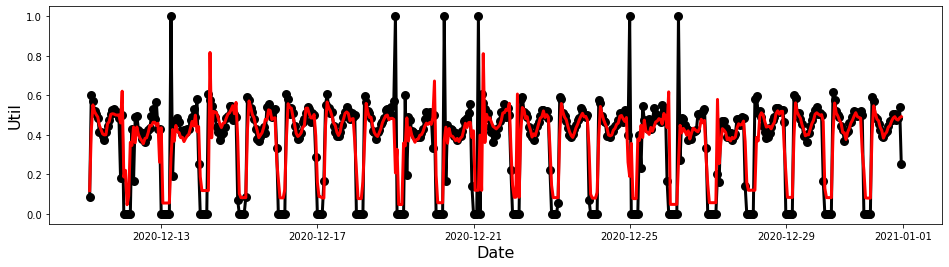

In [20]:
y_pred = ar2.predict(bart_train).to_numpy()
plot_last_five_hundred(x, y, red=y_pred)

In [21]:
start = time.time()
ar3 = smf.ols(formula='transbayUtil ~ travelTime + dayOfWeek + spareAirDay + yesterday + lastHour + sfGiants + oakAs', data=bart_train).fit()
end = time.time()
print(ar3.summary())
print('Training RMSE:', round(RMSE(bart_train['transbayUtil'], ar3.predict(bart_train)), 3))
print('Training MAE:', round(MAE(bart_train['transbayUtil'], ar3.predict(bart_train)), 3))
autoreg_time = start-end

                            OLS Regression Results                            
Dep. Variable:           transbayUtil   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     8113.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:03:28   Log-Likelihood:                 58521.
No. Observations:               87648   AIC:                        -1.170e+05
Df Residuals:                   87635   BIC:                        -1.169e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [22]:
cols = ['travelTime', 'spareAirDay', 'yesterday', 'lastHour', 'sfGiants', 'oakAs']
VIF(bart_train[24:], cols)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


travelTime     1.072693
spareAirDay    1.004269
yesterday      1.242243
lastHour       1.260084
sfGiants       1.021529
oakAs          1.015710
dtype: float64

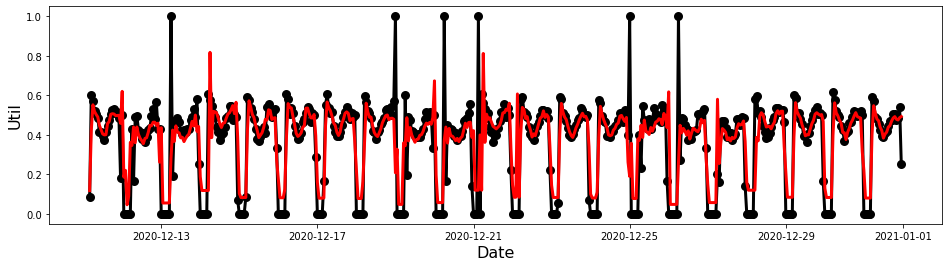

In [23]:
y_pred = ar3.predict(bart_train).to_numpy()
plot_last_five_hundred(x, y, red=y_pred)

## Part VI: Neural Network Model

In [24]:
X_train = pd.get_dummies(bart_train, columns=['dayOfWeek'])
X_test = pd.get_dummies(bart_test, columns=['dayOfWeek'])
X_train.head()

,datetime,transbayRides,systemRides,transbayUtil,travelTime,sfoAirTemp,sfoPrecip,oakAirTemp,oakPrecip,spareAirDay,...,lastHour,sfGiants,oakAs,dayOfWeek_Friday,dayOfWeek_Monday,dayOfWeek_Saturday,dayOfWeek_Sunday,dayOfWeek_Thursday,dayOfWeek_Tuesday,dayOfWeek_Wednesday
0,2011-01-01 00:00:00,2473.0,5175.0,0.477874,15.669167,8.9,0.0,8.9,-0.1,0.0,...,NaN,0,0,0,0,1,0,0,0,0
1,2011-01-01 01:00:00,9884.0,15479.0,0.638543,16.778333,8.9,0.3,8.9,0.3,0.0,...,0.477874,0,0,0,0,1,0,0,0,0
2,2011-01-01 02:00:00,7050.0,11055.0,0.637720,16.237500,8.3,0.5,8.9,0.3,0.0,...,0.638543,0,0,0,0,1,0,0,0,0
3,2011-01-01 03:00:00,4135.0,5592.0,0.739449,15.604167,8.9,-0.1,8.9,0.3,0.0,...,0.637720,0,0,0,0,1,0,0,0,0
4,2011-01-01 04:00:00,686.0,795.0,0.862893,15.732500,8.9,-0.1,9.4,-0.1,0.0,...,0.739449,0,0,0,0,1,0,0,0,0


In [25]:
y_train = X_train['transbayUtil']
y_test = X_test['transbayUtil']
X_train.drop(columns=['datetime', 'transbayRides', 'systemRides', 'transbayUtil'], inplace=True)
X_test.drop(columns=['datetime', 'transbayRides', 'systemRides', 'transbayUtil'], inplace=True)
X_train = X_train[24:]
y_train = y_train[24:]
print(X_train.shape)

(87648, 17)


In [26]:
y_train_nn = y_train.to_numpy()
y_test_nn = y_test.to_numpy()
X_train_nn = X_train.to_numpy()
X_test_nn = X_test.to_numpy()

In [27]:
nn = Sequential()
nn.add(Input(shape=(17,)))
nn.add(Dense(10, activation='relu'))
nn.add(Dense(5, activation='relu'))
nn.add(Dense(1))

opt = RMSprop()
nn.compile(optimizer=opt,
                 loss='mse',
               metrics=['mean_squared_error', 'mean_absolute_error'])

## Training the model
start = time.time()
nn.fit(X_train_nn, y_train_nn, epochs=10, batch_size=64, validation_split=0.2)
end = time.time()
neural_time = end - start

Epoch 1/10
1096/1096 [==============================] - 4s 3ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1289 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.0935
Epoch 2/10
1096/1096 [==============================] - 3s 3ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0727 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.0915
Epoch 3/10
1096/1096 [==============================] - 3s 2ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolute_error: 0.0706 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.0774
Epoch 4/10
1096/1096 [==============================] - 3s 2ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0703 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.0777
Epoch 5/10
1096/1096 [==============================] - 3s 3ms/step - loss: 0.0152 - mea

In [28]:
nn.summary()
loss, rmse, mae = nn.evaluate(X_train_nn, y_train_nn)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                180       
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - mean_absolute_error: 0.0753


In [29]:
nn_pred_train = nn.predict(X_train_nn)
print('Training RMSE:', round(RMSE(y_train_nn, nn_pred_train.flatten()), 4))
print('Training MAE:', round(MAE(y_train_nn, nn_pred_train.flatten()), 4))
print('Training R^2:', round(OSR2(y_train_nn, y_train_nn, nn_pred_train.flatten()), 4))

2739/2739 [==============================] - 4s 2ms/step
Training RMSE: 0.128
Training MAE: 0.0753
Training R^2: 0.496


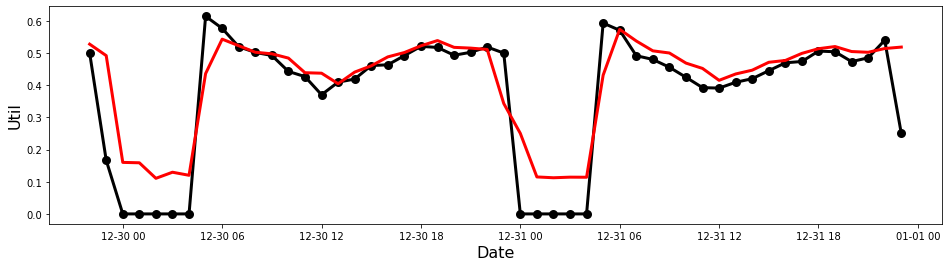

In [30]:
x = bart_train['datetime'].to_numpy()
y = bart_train['transbayUtil'].to_numpy()
plot_last_fifty(x, y, red=nn_pred_train.flatten())

## Part VII: Tree Models

In [31]:
def OSR2_tree(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

def OSR2_pred(y_pred, y_train, y_test):
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

In [32]:
# train
train = bart_train.drop(['datetime'], axis = 1)
train = train.replace('Sunday', 1).replace('Monday', 2).replace('Tuesday', 3).replace('Wednesday', 4).replace('Thursday', 5).replace('Friday', 6).replace('Saturday', 7)
X_train = train.drop(['transbayRides', 'systemRides', 'transbayUtil'], axis = 1)
y_train = train['transbayUtil']

X_train = X_train.iloc[24:]
y_train = y_train.iloc[24:]

# test
test = bart_test.drop(['datetime'], axis =1)
test = test.replace('Sunday', 1).replace('Monday', 2).replace('Tuesday', 3).replace('Wednesday', 4).replace('Thursday', 5).replace('Friday', 6).replace('Saturday', 7)
X_test = test.drop(['transbayRides', 'systemRides', 'transbayUtil'], axis = 1)
y_test = test['transbayUtil']

In [33]:
X_train.head()

,travelTime,dayOfWeek,sfoAirTemp,sfoPrecip,oakAirTemp,oakPrecip,spareAirDay,yesterday,lastHour,sfGiants,oakAs
24,15.315000,1,10.6,-0.1,8.3,0.0,0.0,0.477874,0.471289,0,0
25,15.292500,1,10.6,0.0,9.4,-0.1,0.0,0.638543,0.488731,0,0
26,15.355000,1,10.6,-0.1,8.9,-0.1,0.0,0.637720,0.545763,0,0
27,15.314167,1,10.6,0.3,8.9,-0.1,0.0,0.739449,0.000000,0,0
28,15.406667,1,10.0,1.0,10.0,-0.1,0.0,0.862893,0.000000,0,0


### Section A: CART

In [34]:
# decision tree regressor
dtr1 = DecisionTreeRegressor(min_samples_leaf = 5, min_samples_split = 20, random_state = 88)
dtr1 = dtr1.fit(X_train, y_train)

dtr1_pred = dtr1.predict(X_train)

In [61]:
# performance 
from sklearn.metrics import mean_absolute_error

dtr1_r1 = OSR2_pred(y_train, y_train, dtr1_pred)
dtr1_rmse = RMSE(y_train, dtr1_pred)
dtr1_mae = mean_absolute_error(y_train, dtr1_pred)

pd.DataFrame(data = {'R^2': [dtr1_r1], 'RMSE': [dtr1_rmse], 'MAE': [dtr1_mae]})

,R^2,RMSE,MAE
0,0.737318,0.082242,0.033372


In [36]:
# Cross-Validated decision tree regressor 
start = time.time()
cp_params = {'ccp_alpha': np.linspace(0,0.1,20)}

dtr2 = DecisionTreeRegressor(min_samples_leaf = 5,
                             min_samples_split = 20,
                             random_state = 88)
dtr2_cv = GridSearchCV(dtr2, 
                       param_grid = cp_params,
                       scoring = 'r2',
                       cv = 5,
                       verbose = 0)
dtr2_cv.fit(X_train, y_train)
dtr2_cv.best_params_
cart_time = time.time() - start

In [37]:
print(cart_time)

76.04785370826721


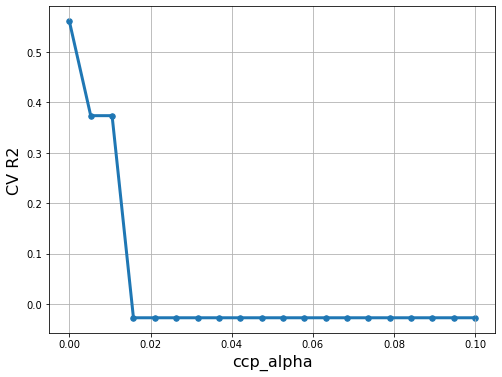

In [38]:
# select the best hyperparameter
ccp_alphas = dtr2_cv.cv_results_['param_ccp_alpha'].data
R2_scores = dtr2_cv.cv_results_['mean_test_score']
plt.figure(figsize=(8, 6))
plt.xlabel('ccp_alpha', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(ccp_alphas, R2_scores, s=30)
plt.plot(ccp_alphas, R2_scores, linewidth=3)
plt.grid(True, which='both')

In [39]:
# check performance 
dtr2_best = dtr2_cv.best_estimator_
dtr2_pred = dtr2_best.predict(X_train)

dtr2_r2 = OSR2(y_train, y_train, dtr2_pred)
dtr2_rmse = RMSE(y_train, dtr2_pred)
dtr2_mae = mean_absolute_error(y_train, dtr2_pred)

pd.DataFrame(data = {'R^2': [dtr2_r2], 'RMSE': [dtr2_rmse], 'MAE': [dtr2_mae]})

,R^2,RMSE,MAE
0,0.791965,0.082242,0.033372


### Section B: Random Forest

In [40]:
# random forest 
rf1 = RandomForestRegressor(max_features = len(X_train.columns),
                                  random_state = 88)
rf1 = rf1.fit(X_train, y_train)

rf1_pred = rf1.predict(X_train)
rf1_r2 = OSR2(y_train, y_train, rf1_pred)
rf1_rmse = RMSE(y_train, rf1_pred)
rf1_mae = mean_absolute_error(y_train, rf1_pred)

pd.DataFrame(data = {'R^2': [rf1_r2], 'RMSE': [rf1_rmse], 'MAE': [rf1_mae]})
# print('Random Forest OSR2:', OSR2_tree(rf1, X_test, y_test, y_train))


,R^2,RMSE,MAE
0,0.953373,0.038936,0.016689


In [41]:
# random forest with CV
# using GridSearchCV to find best max_features:
start = time.time()
params = {'max_features': np.arange(1, len(X_train.columns) + 1)}

rf2 = RandomForestRegressor(random_state = 88)
rf2_cv = GridSearchCV(rf2,
                      param_grid = params,
                      scoring = 'r2',
                      cv = 5,
                      verbose = 0)
rf2_cv = rf2_cv.fit(X_train, y_train)

rf_cv = time.time() - start
print('time:', round(rf_cv, 2),'s')

time: 1628.76 s


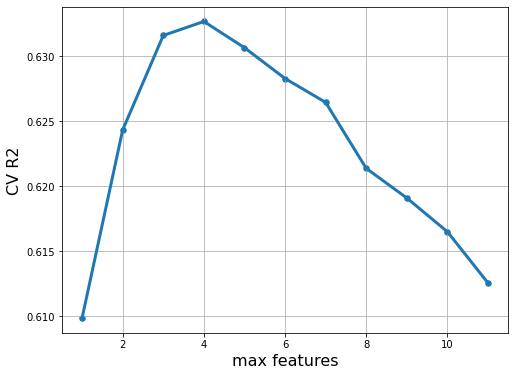

In [42]:
# select the best hyperparameter
max_features = rf2_cv.cv_results_['param_max_features'].data
R2_scores = rf2_cv.cv_results_['mean_test_score']
plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(max_features, R2_scores, s=30)
plt.plot(max_features, R2_scores, linewidth=3)
plt.grid(True, which='both')

In [43]:
rf2_best = rf2_cv.best_estimator_
rf2_pred = rf2_best.predict(X_train)

rf2_cv_r2 = OSR2(y_train, y_train, rf2_pred)
rf2_cv_rmse = RMSE(y_train, rf2_pred)
rf2_cv_mae = mean_absolute_error(y_train, rf2_pred)

pd.DataFrame(data = {'R^2': [rf2_cv_r2], 'RMSE': [rf2_cv_rmse], 'MAE': [rf2_cv_mae]})
# print('Random Forest OSR2:', OSR2_tree(rf1, X_test, y_test, y_train))

,R^2,RMSE,MAE
0,0.955066,0.038222,0.016582


## Part VIII: Bootstrap

In [44]:
def bootstrap(model, X_test, y_test, y_train, sample=500, random_state=66):
    output_array = np.zeros((sample, 3))
    output_array[:] = np.nan
    for bs_iter in range(sample):
        bs_index = np.random.choice(X_test.index, len(X_test.index), replace=True)
        bs_x_test = X_test.loc[bs_index]
        bs_y_test = y_test.loc[bs_index]
        bs_predicted = model.predict(bs_x_test)
        output_array[bs_iter, 0] = OSR2_pred(bs_predicted, y_train, bs_y_test) 
        output_array[bs_iter, 1] = MAE(bs_y_test, bs_predicted)
        output_array[bs_iter, 2] = RMSE(bs_y_test, bs_predicted)
    return output_array

def np_bootstrap(model, X_test, y_test, y_train, sample=500, random_state=66):
    output_array = np.zeros((sample, 3))
    output_array[:] = np.nan
    for bs_iter in range(sample):
        bs_index = np.random.choice(np.arange(len(X_test)), len(X_test), replace=True)
        bs_x_test = X_test[bs_index]
        bs_y_test = y_test[bs_index]
        bs_predicted = model.predict(bs_x_test, verbose=0)
        output_array[bs_iter, 0] = OSR2(y_train, bs_y_test, bs_predicted.flatten())
        output_array[bs_iter, 1] = MAE(bs_y_test, bs_predicted.flatten())
        output_array[bs_iter, 2] = RMSE(bs_y_test, bs_predicted.flatten())
    return output_array

def perform_bootstrap(X_test_tree, y_test_tree, y_train_tree, X_test, y_test, y_train, model_dict, B=500, random_state=88) -> dict: 
    dictionary = {}

    np.random.seed(random_state)
    for key in model_dict:
        model = model_dict[key]
        if (key == 'Random Forest'):
            model_array = bootstrap(model, X_test_tree, y_test_tree, y_train_tree, B, random_state)
        else:
          model_array = bootstrap(model, X_test, y_test, y_train, B, random_state)
        dictionary[str(key)] = model_array
        
    return dictionary

In [53]:
boots = [] 
boots.append(bootstrap(ar3, bart_test, bart_test['transbayUtil'], bart_train['transbayUtil']))
boots.append(np_bootstrap(nn, X_test_nn, y_test_nn, y_train_nn))
boots.append(bootstrap(dtr2_best, X_test, y_test, y_train))
boots.append(bootstrap(rf2_cv.best_estimator_, X_test, y_test, y_train))
boots = np.array(boots)

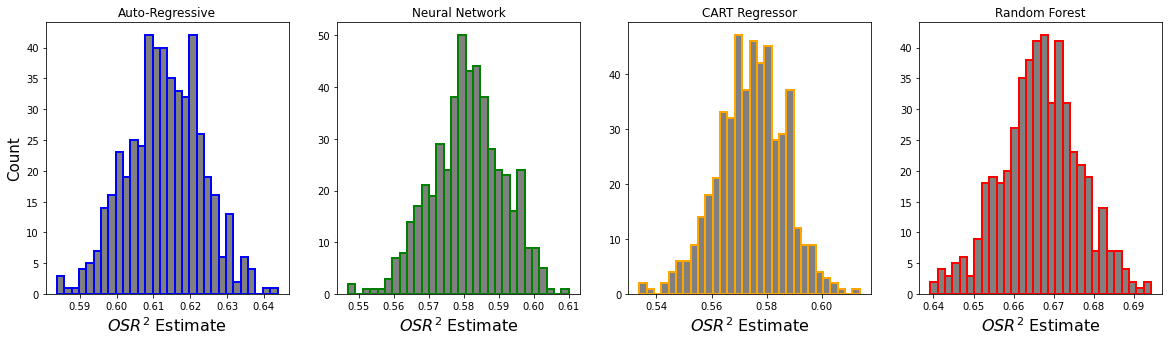

In [56]:
n = len(boots)
names = ['Auto-Regressive', 'Neural Network', 'CART Regressor','Random Forest']
colors = ['blue', 'green', 'orange', 'red', 'purple']
plt.rcParams.update({'font.size': 10})
fig, axs = plt.subplots(ncols=n, figsize=(20,5))
axs[0].set_ylabel('Count', fontsize=15)
for i in range(n):
    axs[i].set_xlabel('$OSR^2$ Estimate', fontsize=16)
    axs[i].set_title(names[i])
    _ = axs[i].hist(boots[i,:,0], bins=30, edgecolor= colors[i], linewidth=2, color="grey")

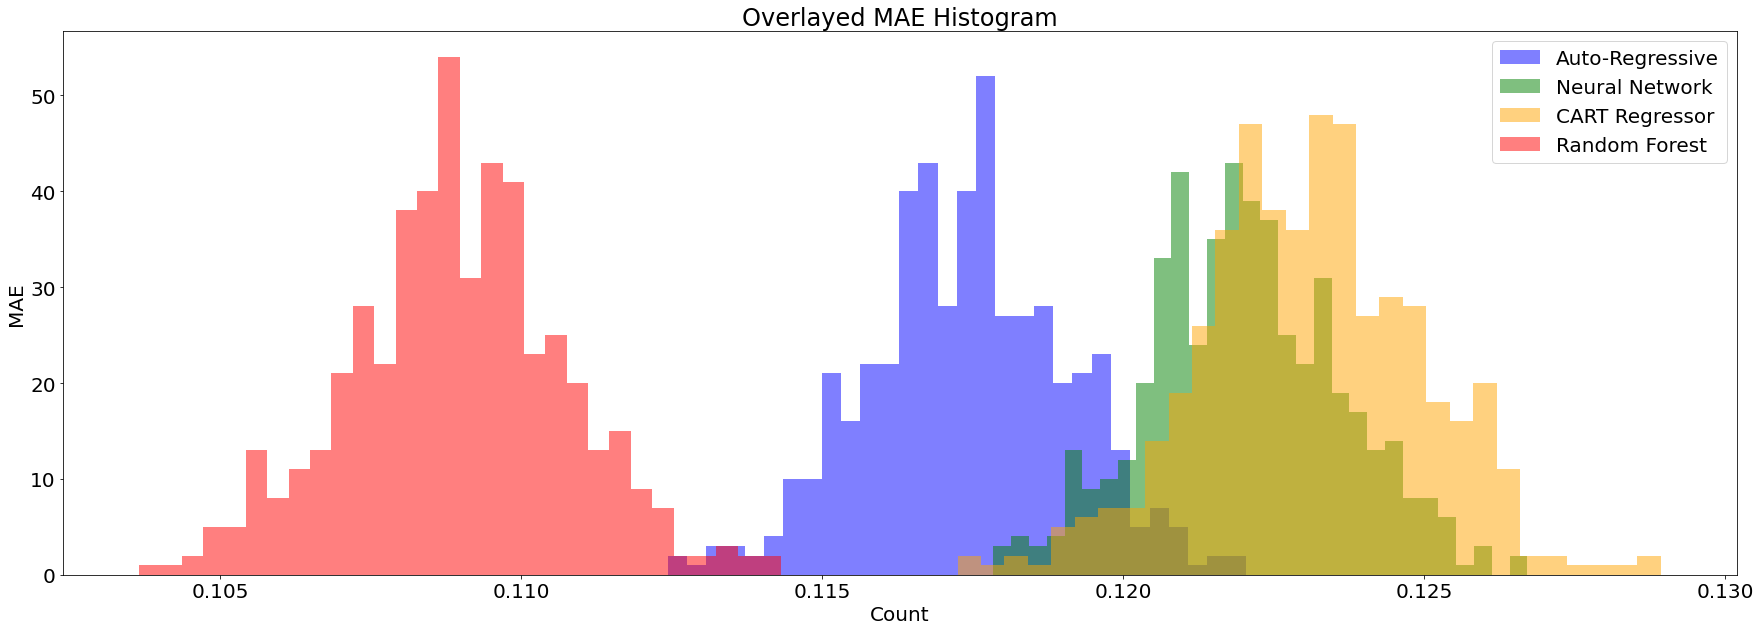

In [68]:
plt.figure(figsize=(30, 10))
plt.rcParams.update({'font.size': 20})
plt.title('Overlayed MAE Histogram')
plt.xlabel('Count')
plt.ylabel('MAE')
for i in range(n):
  _ = plt.hist(boots[i,:,2], bins=30, color=colors[i], alpha=0.5)

plt.legend(names)

In [66]:
comparison_data = {'Mean OSR^2': [np.mean(boots[0,:,0]), np.mean(boots[1,:,0]), np.mean(boots[2,:,0]), np.mean(boots[3,:,0])],
                   'OSR^2 Std': [np.std(boots[0,:,0]), np.std(boots[1,:,0]), np.std(boots[2,:,0]), np.std(boots[3,:,0])],
                   'Mean MAE': [np.mean(boots[0,:,1]), np.mean(boots[1,:,1]), np.mean(boots[2,:,1]), np.mean(boots[3,:,1])],
                   'MAE Std': [np.std(boots[0,:,1]), np.std(boots[1,:,1]), np.std(boots[2,:,1]), np.std(boots[3,:,1])],
                   'Mean RMSE': [np.mean(boots[0,:,2]), np.mean(boots[1,:,2]), np.mean(boots[2,:,2]), np.mean(boots[3,:,2])],
                   'RMSE Std': [np.std(boots[0,:,2]), np.std(boots[1,:,2]), np.std(boots[2,:,2]), np.std(boots[3,:,2])]}

comparison_table = pd.DataFrame(data=comparison_data, index=names)
comparison_table.style.set_properties(**{'font-size': '12pt', }).set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '10pt')]}])

,Mean OSR^2,OSR^2 Std,Mean MAE,MAE Std,Mean RMSE,RMSE Std
Auto-Regressive,0.613025,0.010140,0.067212,0.000742,0.117401,0.001658
Neural Network,0.581184,0.010173,0.076096,0.000742,0.122007,0.001603
CART Regressor,0.574451,0.012183,0.060741,0.000867,0.123101,0.001847
Random Forest,0.666700,0.009780,0.055378,0.000724,0.108933,0.001794


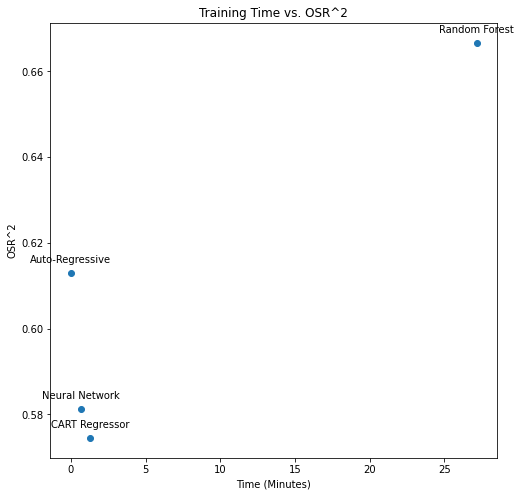

In [67]:
plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': 10})
x = np.divide([autoreg_time, neural_time, cart_time, rf_cv], 60)
y = [np.mean(boots[0,:,0]), np.mean(boots[1,:,0]), np.mean(boots[2,:,0]), np.mean(boots[3,:,0])]
plt.title('Training Time vs. OSR^2')
plt.xlabel('Time (Minutes)')
plt.ylabel('OSR^2')
plt.scatter(x,y)
i = 0
for x,y in zip(x,y):
  plt.annotate(names[i], (x,y), textcoords="offset points", xytext=(0,10), ha='center')
  i = i+1